In [152]:
from IPython.display import clear_output

from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import sys
from polire.interpolate import Kriging
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import rc

from math import sqrt
SPINE_COLOR = 'gray'

In [153]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 10, # fontsize for x and y labels (was 10)
              'axes.titlesize': 10,
              'font.size': 10, # was 10
              'legend.fontsize': 10, # was 10
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)

def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

## Functions

In [154]:
def load_test():
    test_df = pd.DataFrame(columns=test_stations)
    for fold_id, fold in enumerate(folds):
        for file_id, file in enumerate(f_ids):
            test_df.loc[file_id, test_stations[fold_id*len(folds):(fold_id+1)*len(folds)]] =\
            np.load(path+d_name+'/fold_'+fold+'/test/y/'+file+'.npz')['arr_0'].ravel()
    return test_df

def load_results(model_name): # n_test = number of test stations
    pred_df = pd.DataFrame(columns=test_stations)
    for fold_id, fold in enumerate(folds):
        for file_id, file in enumerate(f_ids):
            try:
                val = np.load(path+d_name+'/results/'+model_name+'/fold_'+fold+'/'+file+'.npz')['arr_0'].ravel()
            except Exception as e:
                val = np.nan
                print(model_name,fold_id,file,'not found')
            pred_df.loc[file_id, test_stations[fold_id*len(folds):(fold_id+1)*len(folds)]] = val
    return pred_df

# Global config

In [155]:
path = '../production/pm25_beijing_best36/linear/'
f_ids = [str(i).zfill(5) for i in range(277)]
folds = [str(i) for i in range(6)]
n_test = 6
n_total = 36

## Visualize location of a station

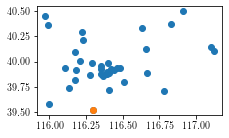

In [156]:
see = 1035

station_df = pd.read_csv('../raw_data/Air20Quality20Data/Beijing/Station.txt').set_index('station_id')
all_locs = station_df[['longtitude', 'latitude']].values
plt.scatter(all_locs[:,0], all_locs[:,1]);
plt.scatter(all_locs[see-1001, 0], all_locs[see-1001, 1]);

### Interpolate empirical covariance matrix

In [157]:
linear_df = pd.read_pickle('../production/pm25_beijing_best36/linear/linear_df.pickle')

cov_df = pd.crosstab(linear_df.index, linear_df.station_id, linear_df.PM25_AQI_value, aggfunc=lambda x:x)
emp_cov = cov_df.cov().values

intr = Kriging(variogram_model='gaussian')
N = 36
x1 = np.linspace(station_df['longtitude'].min()-0.1, station_df['longtitude'].max()+0.1, N)
x2 = np.linspace(station_df['latitude'].min()-0.1, station_df['latitude'].max()+0.1, N)

X1, X2 = np.meshgrid(x1, x2)
X_test = np.array([(i, j) for i, j in zip(X1.ravel(), X2.ravel())])
X_train = station_df[['longtitude', 'latitude']].values
print(X_test.shape, X_train.shape)

s_i = 35
intr.fit(X_train, emp_cov[:,s_i])
y_pred = intr.predict(X_test).reshape(N, N)

(1296, 2) (36, 2)


 /home/patel_zeel/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning:Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


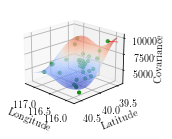

In [158]:
latexify(3.32, 2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, y_pred, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none', alpha=.8)
ax.view_init(20, 135)

ax.scatter(all_locs[:,0], all_locs[:,1], emp_cov[s_i, :], s=10, c='g')

ax.quiver(
        all_locs[s_i,0], all_locs[s_i,1], emp_cov[s_i, s_i], # <-- starting point of vector
        0.2, 0.1, 0.1, # <-- directions of vector
        color = 'red', lw = 0.5,  arrow_length_ratio=0.3, pivot='tip'
    )

ax.set_xlabel('Longitude', labelpad=-0.1)
ax.set_ylabel('Latitude', labelpad=-0.1)
ax.set_zlabel('Covariance', labelpad=-0.1);
# def update(i):
#     ax.view_init(20, 135+i*20)

# anim = FuncAnimation(fig, update, range(18))
# rc('animation', html='jshtml')
# plt.close()
# anim
# fig.tight_layout();
plt.savefig('../production/pm25_beijing_best36/linear/imgs/emp_cov_36.pdf')

## For Long, lat

In [159]:
d_name = 'data2' # Data name
test_stations = []
for fold_id, fold in enumerate(folds):
    test_stations.extend(pd.read_pickle(path+d_name+'/fold_'+fold+'/test_stations.pickle'))
print(test_stations)

[1014, 1017, 1027, 1031, 1032, 1036, 1009, 1010, 1013, 1018, 1022, 1035, 1001, 1005, 1006, 1016, 1020, 1030, 1002, 1003, 1004, 1012, 1025, 1034, 1011, 1019, 1023, 1024, 1028, 1033, 1007, 1008, 1015, 1021, 1026, 1029]


### Load ground truth

In [160]:
res_gt = load_test()

### Load different model results in a DataFrame

In [162]:
res = {model:None for model in ['svr', 'rf', 'dt', 'elst', 'gp_rbf_gpy', 'gp_fi', 
                            'gp_linear', 'gp_m12', 'nsgp_m12', 'gp_m32', 'dkl', 'nsgp_rbf', 
                            'nsgp_rbf_lsq', 'gp_combo', 'mlp']}
for key in res.keys():
#     clear_output(wait=True)
    print('Loading', key)
    res[key] = load_results(key)

Loading svr
Loading rf
Loading dt
Loading elst
Loading gp_rbf_gpy
Loading gp_fi
Loading gp_linear
Loading gp_m12
Loading nsgp_m12
Loading gp_m32
Loading dkl
Loading nsgp_rbf
nsgp_rbf 1 00162 not found
nsgp_rbf 1 00163 not found
Loading nsgp_rbf_lsq
Loading gp_combo
Loading mlp


### Fold wise RMSE & R2

In [163]:
rmse_df = pd.DataFrame(index=res.keys())
rmse_df.index.name = 'RMSE'
r2_df = pd.DataFrame(index=res.keys())
r2_df.index.name = 'R^2'
for key in res:
    if key not in ['']:
        clear_output(wait=True)
        print(key)
        for f_id in range(len(folds)):
            tmp_pred = res[key].iloc[:,f_id*len(folds):(f_id+1)*len(folds)].fillna(method='ffill').values
            tmp_test = res_gt.iloc[:,f_id*len(folds):(f_id+1)*len(folds)].values

            rmse_df.loc[key, f_id] = mean_squared_error(tmp_test.ravel(), tmp_pred.ravel(), squared=False)
            r2_df.loc[key, f_id] = r2_score(tmp_test.ravel(), tmp_pred.ravel())
        rmse_df.loc[key, 'Average'] = rmse_df.loc[key].mean()
        r2_df.loc[key, 'Average'] = r2_df.loc[key].mean()
print(rmse_df.to_markdown())
print()
print(r2_df.to_markdown())

mlp
| RMSE         |       0 |       1 |       2 |       3 |       4 |       5 |   Average |
|:-------------|--------:|--------:|--------:|--------:|--------:|--------:|----------:|
| svr          | 41.9506 | 26.6279 | 28.9802 | 34.0562 | 30.3545 | 25.1556 |   31.1875 |
| rf           | 37.7475 | 25.0327 | 28.5119 | 33.9487 | 28.6126 | 22.768  |   29.4369 |
| dt           | 42.1893 | 31.9746 | 31.7051 | 37.8631 | 34.163  | 28.0299 |   34.3208 |
| elst         | 42.7145 | 30.8063 | 29.4979 | 35.8637 | 30.8736 | 27.0947 |   32.8084 |
| gp_rbf_gpy   | 42.0865 | 26.9805 | 31.3042 | 36.1174 | 28.9685 | 21.5225 |   31.1632 |
| gp_fi        | 39.0082 | 26.7387 | 27.8935 | 35.4986 | 32.6677 | 25.0109 |   31.1363 |
| gp_linear    | 39.7478 | 31.3336 | 28.3218 | 34.8392 | 31.4922 | 27.8865 |   32.2702 |
| gp_m12       | 40.5281 | 25.7021 | 29.6133 | 35.6225 | 27.6098 | 21.7113 |   30.1312 |
| nsgp_m12     | 45.2993 | 25.0475 | 28.2451 | 34.9389 | 27.8292 | 22.5558 |   30.6526 |
| gp_m32       | 

In [164]:
print(rmse_df[['Average']].round(2).drop(['gp_fi','dt', 'dkl', 'nsgp_rbf_lsq', 'gp_combo'], axis=0).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Average \\
RMSE       &          \\
\midrule
svr        &    31.19 \\
rf         &    29.44 \\
elst       &    32.81 \\
gp\_rbf\_gpy &    31.16 \\
gp\_linear  &    32.27 \\
gp\_m12     &    30.13 \\
nsgp\_m12   &    30.65 \\
gp\_m32     &    30.85 \\
nsgp\_rbf   &    30.30 \\
mlp        &    35.26 \\
\bottomrule
\end{tabular}



### Station-wise RMSE

rf


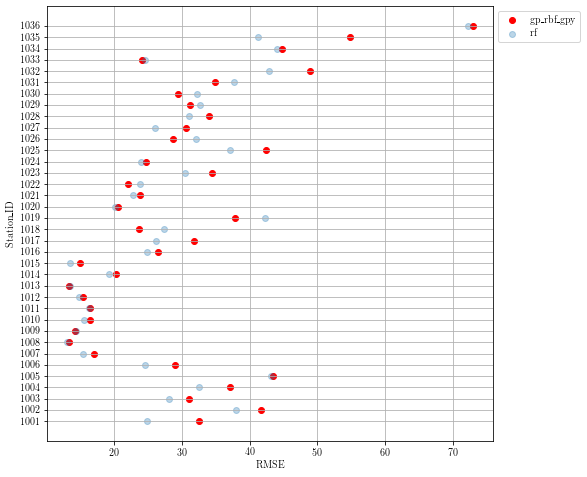

In [81]:
plt.figure(figsize=(8,8))
custom = ['gp_rbf_gpy', 'rf']
for key in custom:
    if key not in ['gp_combo']:
        clear_output(wait=True)
        print(key)
        if key == 'gp_rbf_gpy':
            plt.scatter(np.sqrt(np.mean(np.square(res[key] - res_gt), axis=0)), res_gt.columns, label=key.replace('_','\\_'), c='r')
        else:
            plt.scatter(np.sqrt(np.mean(np.square(res[key] - res_gt), axis=0)), res_gt.columns, label=key.replace('_','\\_'), alpha=0.3)
plt.legend(bbox_to_anchor=(1,1));
plt.yticks(range(1001,1037))
plt.xlabel('RMSE'); plt.ylabel('Station\_ID')
plt.grid(True);

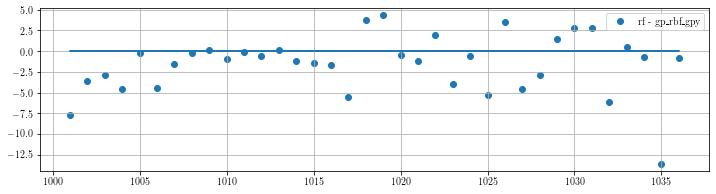

In [83]:
plt.figure(figsize=(12,3))
custom = ['gp_rbf_gpy', 'rf']
c1 = np.sqrt(np.mean(np.square(res[custom[0]] - res_gt)))
c2 = np.sqrt(np.mean(np.square(res[custom[1]] - res_gt)))
plt.plot(c1.index, np.zeros(c1.shape[0]));
diff_df = c2-c1
plt.scatter(diff_df.index, diff_df, label=custom[1].replace('_','\\_')+' - '+custom[0].replace('_','\\_'));
plt.legend(bbox_to_anchor=(1,1));
plt.grid(1);

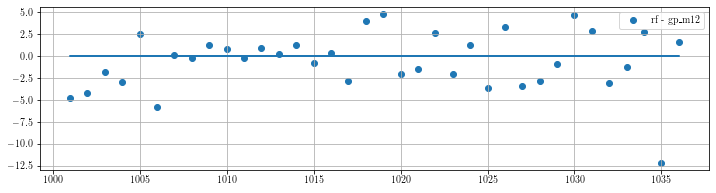

In [84]:
plt.figure(figsize=(12,3))
custom = ['gp_m12', 'rf']
c1 = np.sqrt(np.mean(np.square(res[custom[0]] - res_gt)))
c2 = np.sqrt(np.mean(np.square(res[custom[1]] - res_gt)))
plt.plot(c1.index, np.zeros(c1.shape[0]));
diff_df = c2-c1
plt.scatter(diff_df.index, diff_df, label=custom[1].replace('_','\\_')+' - '+custom[0].replace('_','\\_'));
plt.legend(bbox_to_anchor=(1,1));
plt.grid(1);

### For station 1035, GP is very bad than RF, checking,

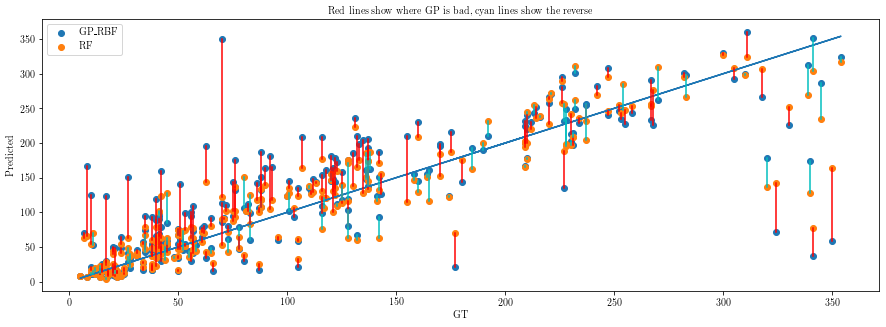

In [86]:
plt.figure(figsize=(15,5))
plt.plot(res_gt[1035], res_gt[1035])
# plt.scatter(res_gt[1035], res['gp_rbf_gpy'][1035], label='GP_RBF');
plt.scatter(res_gt[1035], res['gp_rbf_gpy'][1035], label='GP\_RBF');
plt.scatter(res_gt[1035], res['rf'][1035], label='RF');
c = ['c' if i-j>=0 else 'r' for i,j in zip(np.abs(res_gt[1035]-res['rf'][1035]), np.abs(res_gt[1035]-res['gp_rbf_gpy'][1035]))]
for i in range(res_gt.shape[0]):
    plt.plot([res_gt[1035][i], res_gt[1035][i]], [res['gp_rbf_gpy'][1035][i], res['rf'][1035][i]], c=c[i]);
plt.legend();
plt.xlabel('GT');plt.ylabel('Predicted');
plt.title('Red lines show where GP is bad, cyan lines show the reverse');

In [87]:
np.argmax(np.abs(res['gp_rbf_gpy'][1035] - res['rf'][1035])) # Max difference between two

143

In [88]:
np.argmax(np.abs(res['gp_rbf_gpy'][1035] - res_gt[1035])) # Bad most prediction

141

In [89]:
drop_id = 142
print(np.sqrt(np.square(res_gt[1035] - res['gp_rbf_gpy'][1035]).mean()), np.sqrt(np.square(res_gt[1035] - res['rf'][1035]).mean()))

print(np.sqrt(np.square(res_gt[1035].drop(drop_id, axis=0) - res['gp_rbf_gpy'][1035].drop(drop_id, axis=0)).mean()), 
      np.sqrt(np.square(res_gt[1035] - res['rf'][1035]).mean()))

54.822778462268275 41.2479234847636
54.11263551210469 41.2479234847636


In [90]:
res_gt[1035][drop_id], res['gp_rbf_gpy'][1035][drop_id], res['rf'][1035][drop_id]

(177.0, 20.933287581017012, 69.91413765056154)

array([[ 11.98255859],
       [ 12.00426253],
       [ 11.6999609 ],
       [ 15.35892479],
       [ 11.69585787],
       [129.09214532]])

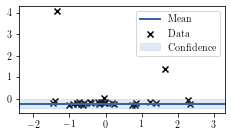

In [91]:
model = pd.read_pickle('../production/pm25_beijing_best36/linear/data2/results/gp_rbf_gpy/fold_1/00'+str(drop_id)+'.model')
# fig, ax = plt.subplots();
model.plot(visible_dims=[0]);

scaler = pd.read_pickle('../production/pm25_beijing_best36/linear/data2/fold_1/scaler/00'+str(drop_id)+'.pickle')
trn_y = np.load('../production/pm25_beijing_best36/linear/data2/fold_1/train/y/00'+str(drop_id)+'.npz')['arr_0']
trn_y_unscaled = scaler.inverse_transform(trn_y)
np.sqrt(model.predict(np.load('../production/pm25_beijing_best36/linear/data2/fold_1/test/X/00'+str(drop_id)+'.npz')['arr_0'])[1]*np.var(trn_y_unscaled))*2

## For All features

In [167]:
d_name = 'data10' # Data name
test_stations = []
for fold_id, fold in enumerate(folds):
    test_stations.extend(pd.read_pickle(path+d_name+'/fold_'+fold+'/test_stations.pickle'))
print(test_stations)

[1014, 1017, 1027, 1031, 1032, 1036, 1009, 1010, 1013, 1018, 1022, 1035, 1001, 1005, 1006, 1016, 1020, 1030, 1002, 1003, 1004, 1012, 1025, 1034, 1011, 1019, 1023, 1024, 1028, 1033, 1007, 1008, 1015, 1021, 1026, 1029]


### Load ground truth

In [168]:
res_gt = load_test()

### Load different model results in a DataFrame

In [169]:
res = {model:None for model in ['svr', 'rf', 'dt', 'elst', 'gp_rbf_gpy', 'gp_fi', 
                            'gp_linear', 'gp_m12', 'nsgp_m12', 'gp_m32', 'dkl', 'nsgp_rbf', 
                            'nsgp_rbf_lsq', 'gp_combo', 'mlp']}
for key in res.keys():
#     clear_output(wait=True)
    print('Loading', key)
    res[key] = load_results(key)

Loading svr
Loading rf
Loading dt
Loading elst
Loading gp_rbf_gpy
Loading gp_fi
Loading gp_linear
Loading gp_m12
Loading nsgp_m12
nsgp_m12 0 00000 not found
nsgp_m12 0 00001 not found
nsgp_m12 0 00002 not found
nsgp_m12 0 00003 not found
nsgp_m12 0 00004 not found
nsgp_m12 0 00005 not found
nsgp_m12 0 00006 not found
nsgp_m12 0 00007 not found
nsgp_m12 0 00008 not found
nsgp_m12 0 00009 not found
nsgp_m12 0 00010 not found
nsgp_m12 0 00011 not found
nsgp_m12 0 00012 not found
nsgp_m12 0 00013 not found
nsgp_m12 0 00014 not found
nsgp_m12 0 00015 not found
nsgp_m12 0 00016 not found
nsgp_m12 0 00017 not found
nsgp_m12 0 00018 not found
nsgp_m12 0 00019 not found
nsgp_m12 0 00020 not found
nsgp_m12 0 00021 not found
nsgp_m12 0 00022 not found
nsgp_m12 0 00023 not found
nsgp_m12 0 00024 not found
nsgp_m12 0 00025 not found
nsgp_m12 0 00026 not found
nsgp_m12 0 00027 not found
nsgp_m12 0 00028 not found
nsgp_m12 0 00029 not found
nsgp_m12 0 00030 not found
nsgp_m12 0 00031 not found
nsgp_m

nsgp_m12 1 00212 not found
nsgp_m12 1 00213 not found
nsgp_m12 1 00214 not found
nsgp_m12 1 00215 not found
nsgp_m12 1 00216 not found
nsgp_m12 1 00217 not found
nsgp_m12 1 00218 not found
nsgp_m12 1 00219 not found
nsgp_m12 1 00220 not found
nsgp_m12 1 00221 not found
nsgp_m12 1 00222 not found
nsgp_m12 1 00223 not found
nsgp_m12 1 00224 not found
nsgp_m12 1 00225 not found
nsgp_m12 1 00226 not found
nsgp_m12 1 00227 not found
nsgp_m12 1 00228 not found
nsgp_m12 1 00229 not found
nsgp_m12 1 00230 not found
nsgp_m12 1 00231 not found
nsgp_m12 1 00232 not found
nsgp_m12 1 00233 not found
nsgp_m12 1 00234 not found
nsgp_m12 1 00235 not found
nsgp_m12 1 00236 not found
nsgp_m12 1 00237 not found
nsgp_m12 1 00238 not found
nsgp_m12 1 00239 not found
nsgp_m12 1 00240 not found
nsgp_m12 1 00241 not found
nsgp_m12 1 00242 not found
nsgp_m12 1 00243 not found
nsgp_m12 1 00244 not found
nsgp_m12 1 00245 not found
nsgp_m12 1 00246 not found
nsgp_m12 1 00247 not found
nsgp_m12 1 00248 not found
n

nsgp_m12 3 00060 not found
nsgp_m12 3 00061 not found
nsgp_m12 3 00062 not found
nsgp_m12 3 00063 not found
nsgp_m12 3 00064 not found
nsgp_m12 3 00065 not found
nsgp_m12 3 00066 not found
nsgp_m12 3 00067 not found
nsgp_m12 3 00068 not found
nsgp_m12 3 00069 not found
nsgp_m12 3 00070 not found
nsgp_m12 3 00071 not found
nsgp_m12 3 00072 not found
nsgp_m12 3 00073 not found
nsgp_m12 3 00074 not found
nsgp_m12 3 00075 not found
nsgp_m12 3 00076 not found
nsgp_m12 3 00077 not found
nsgp_m12 3 00078 not found
nsgp_m12 3 00079 not found
nsgp_m12 3 00080 not found
nsgp_m12 3 00081 not found
nsgp_m12 3 00082 not found
nsgp_m12 3 00083 not found
nsgp_m12 3 00084 not found
nsgp_m12 3 00085 not found
nsgp_m12 3 00086 not found
nsgp_m12 3 00087 not found
nsgp_m12 3 00088 not found
nsgp_m12 3 00089 not found
nsgp_m12 3 00090 not found
nsgp_m12 3 00091 not found
nsgp_m12 3 00092 not found
nsgp_m12 3 00093 not found
nsgp_m12 3 00094 not found
nsgp_m12 3 00095 not found
nsgp_m12 3 00096 not found
n

nsgp_m12 4 00147 not found
nsgp_m12 4 00148 not found
nsgp_m12 4 00149 not found
nsgp_m12 4 00150 not found
nsgp_m12 4 00151 not found
nsgp_m12 4 00152 not found
nsgp_m12 4 00153 not found
nsgp_m12 4 00154 not found
nsgp_m12 4 00155 not found
nsgp_m12 4 00156 not found
nsgp_m12 4 00157 not found
nsgp_m12 4 00158 not found
nsgp_m12 4 00159 not found
nsgp_m12 4 00160 not found
nsgp_m12 4 00161 not found
nsgp_m12 4 00162 not found
nsgp_m12 4 00163 not found
nsgp_m12 4 00164 not found
nsgp_m12 4 00165 not found
nsgp_m12 4 00166 not found
nsgp_m12 4 00167 not found
nsgp_m12 4 00168 not found
nsgp_m12 4 00169 not found
nsgp_m12 4 00170 not found
nsgp_m12 4 00171 not found
nsgp_m12 4 00172 not found
nsgp_m12 4 00173 not found
nsgp_m12 4 00174 not found
nsgp_m12 4 00175 not found
nsgp_m12 4 00176 not found
nsgp_m12 4 00177 not found
nsgp_m12 4 00178 not found
nsgp_m12 4 00179 not found
nsgp_m12 4 00180 not found
nsgp_m12 4 00181 not found
nsgp_m12 4 00182 not found
nsgp_m12 4 00183 not found
n

nsgp_m12 5 00276 not found
Loading gp_m32
Loading dkl
Loading nsgp_rbf
Loading nsgp_rbf_lsq
Loading gp_combo
Loading mlp


### Fold wise RMSE & R2

In [171]:
rmse_df = pd.DataFrame(index=res.keys())
rmse_df.index.name = 'RMSE'
r2_df = pd.DataFrame(index=res.keys())
r2_df.index.name = 'R^2'
for key in res:
    if key not in ['nsgp_m12']:
        clear_output(wait=True)
        print(key)
        for f_id in range(len(folds)):
            tmp_pred = res[key].iloc[:,f_id*len(folds):(f_id+1)*len(folds)].fillna(method='ffill').values
            tmp_test = res_gt.iloc[:,f_id*len(folds):(f_id+1)*len(folds)].values

            rmse_df.loc[key, f_id] = mean_squared_error(tmp_test.ravel(), tmp_pred.ravel(), squared=False)
            r2_df.loc[key, f_id] = r2_score(tmp_test.ravel(), tmp_pred.ravel())
        rmse_df.loc[key, 'Average'] = rmse_df.loc[key].mean()
        r2_df.loc[key, 'Average'] = r2_df.loc[key].mean()
print(rmse_df.to_markdown())
print()
print(r2_df.to_markdown())

mlp
| RMSE         |        0 |        1 |        2 |        3 |        4 |        5 |   Average |
|:-------------|---------:|---------:|---------:|---------:|---------:|---------:|----------:|
| svr          |  43.2854 |  26.3845 |  28.6245 |  33.654  |  29.6527 |  26.5435 |   31.3574 |
| rf           |  41.243  |  24.6615 |  29.2593 |  33.7415 |  29.2071 |  23.093  |   30.2009 |
| dt           |  41.4782 |  32.9321 |  33.5871 |  37.5735 |  34.7133 |  28.2368 |   34.7535 |
| elst         |  42.1996 |  29.8669 |  28.9663 |  34.8669 |  31.2633 |  26.4264 |   32.2649 |
| gp_rbf_gpy   |  43.4103 |  27.9742 |  31.0088 |  36.8013 |  29.52   |  22.544  |   31.8764 |
| gp_fi        |  39.5653 |  26.6724 |  27.3904 |  35.2577 |  32.7043 |  25.1794 |   31.1282 |
| gp_linear    |  39.869  |  30.7726 |  28.5977 |  34.9883 |  32.9202 |  27.6218 |   32.4616 |
| gp_m12       |  41.4882 |  27.0646 |  29.6579 |  35.2948 |  29.0128 |  22.879  |   30.8996 |
| nsgp_m12     | nan      | nan      | nan    

In [172]:
print(rmse_df[['Average']].round(2).drop(['gp_fi','dt', 'dkl', 'nsgp_rbf_lsq', 'gp_combo'], axis=0).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Average \\
RMSE       &          \\
\midrule
svr        &    31.36 \\
rf         &    30.20 \\
elst       &    32.26 \\
gp\_rbf\_gpy &    31.88 \\
gp\_linear  &    32.46 \\
gp\_m12     &    30.90 \\
nsgp\_m12   &      NaN \\
gp\_m32     &    31.52 \\
nsgp\_rbf   &    35.66 \\
mlp        &    34.80 \\
\bottomrule
\end{tabular}



### Station-wise RMSE

rf


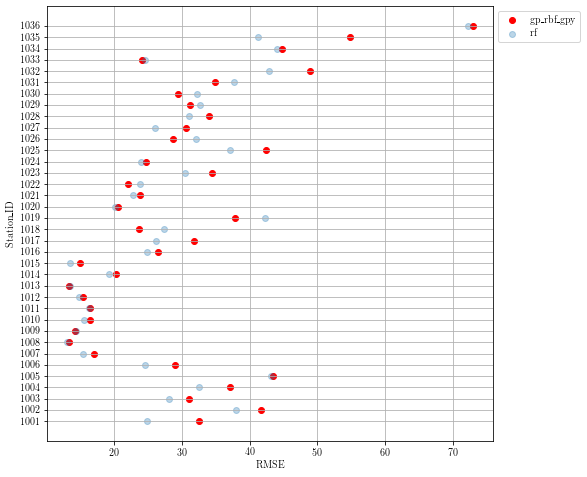

In [173]:
plt.figure(figsize=(8,8))
custom = ['gp_rbf_gpy', 'rf']
for key in custom:
    if key not in ['gp_combo']:
        clear_output(wait=True)
        print(key)
        if key == 'gp_rbf_gpy':
            plt.scatter(np.sqrt(np.mean(np.square(res[key] - res_gt), axis=0)), res_gt.columns, label=key.replace('_','\\_'), c='r')
        else:
            plt.scatter(np.sqrt(np.mean(np.square(res[key] - res_gt), axis=0)), res_gt.columns, label=key.replace('_','\\_'), alpha=0.3)
plt.legend(bbox_to_anchor=(1,1));
plt.yticks(range(1001,1037))
plt.xlabel('RMSE'); plt.ylabel('Station\_ID')
plt.grid(True);

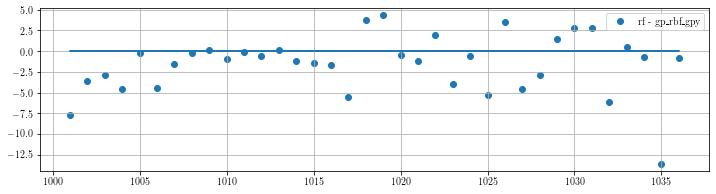

In [174]:
plt.figure(figsize=(12,3))
custom = ['gp_rbf_gpy', 'rf']
c1 = np.sqrt(np.mean(np.square(res[custom[0]] - res_gt)))
c2 = np.sqrt(np.mean(np.square(res[custom[1]] - res_gt)))
plt.plot(c1.index, np.zeros(c1.shape[0]));
diff_df = c2-c1
plt.scatter(diff_df.index, diff_df, label=custom[1].replace('_','\\_')+' - '+custom[0].replace('_','\\_'));
plt.legend(bbox_to_anchor=(1,1));
plt.grid(1);

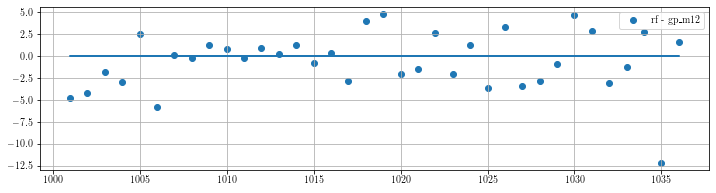

In [175]:
plt.figure(figsize=(12,3))
custom = ['gp_m12', 'rf']
c1 = np.sqrt(np.mean(np.square(res[custom[0]] - res_gt)))
c2 = np.sqrt(np.mean(np.square(res[custom[1]] - res_gt)))
plt.plot(c1.index, np.zeros(c1.shape[0]));
diff_df = c2-c1
plt.scatter(diff_df.index, diff_df, label=custom[1].replace('_','\\_')+' - '+custom[0].replace('_','\\_'));
plt.legend(bbox_to_anchor=(1,1));
plt.grid(1);

### For station 1035, GP is very bad than RF, checking,

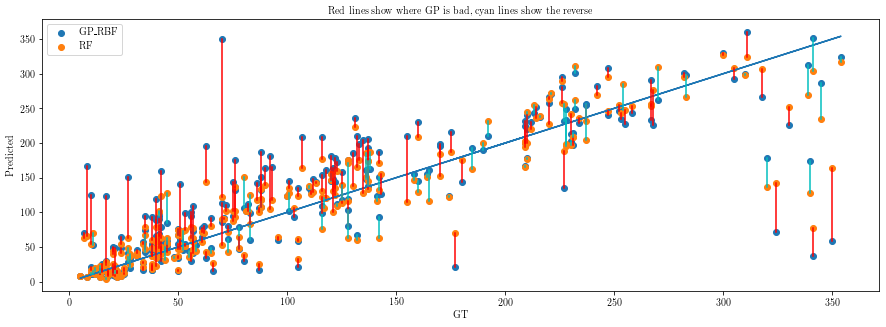

In [176]:
plt.figure(figsize=(15,5))
plt.plot(res_gt[1035], res_gt[1035])
# plt.scatter(res_gt[1035], res['gp_rbf_gpy'][1035], label='GP_RBF');
plt.scatter(res_gt[1035], res['gp_rbf_gpy'][1035], label='GP\_RBF');
plt.scatter(res_gt[1035], res['rf'][1035], label='RF');
c = ['c' if i-j>=0 else 'r' for i,j in zip(np.abs(res_gt[1035]-res['rf'][1035]), np.abs(res_gt[1035]-res['gp_rbf_gpy'][1035]))]
for i in range(res_gt.shape[0]):
    plt.plot([res_gt[1035][i], res_gt[1035][i]], [res['gp_rbf_gpy'][1035][i], res['rf'][1035][i]], c=c[i]);
plt.legend();
plt.xlabel('GT');plt.ylabel('Predicted');
plt.title('Red lines show where GP is bad, cyan lines show the reverse');

In [177]:
np.argmax(np.abs(res['gp_rbf_gpy'][1035] - res['rf'][1035])) # Max difference between two

143

In [178]:
np.argmax(np.abs(res['gp_rbf_gpy'][1035] - res_gt[1035])) # Bad most prediction

141

In [179]:
drop_id = 143
print(np.sqrt(np.square(res_gt[1035] - res['gp_rbf_gpy'][1035]).mean()), np.sqrt(np.square(res_gt[1035] - res['rf'][1035]).mean()))

print(np.sqrt(np.square(res_gt[1035].drop(drop_id, axis=0) - res['gp_rbf_gpy'][1035].drop(drop_id, axis=0)).mean()), 
      np.sqrt(np.square(res_gt[1035] - res['rf'][1035]).mean()))

54.822778462268275 41.2479234847636
52.278476759334296 41.2479234847636


In [180]:
res_gt[1035][drop_id], res['gp_rbf_gpy'][1035][drop_id], res['rf'][1035][drop_id]

(70.0, 349.66937463227794, 122.68)

array([[ 7.27093379],
       [ 7.29597787],
       [ 7.18405701],
       [ 8.73119054],
       [ 7.20682548],
       [33.30264294]])

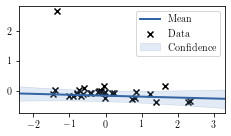

In [181]:
model = pd.read_pickle('../production/pm25_beijing_best36/linear/data2/results/gp_rbf_gpy/fold_1/00'+str(drop_id)+'.model')
# fig, ax = plt.subplots();
model.plot(visible_dims=[0]);

scaler = pd.read_pickle('../production/pm25_beijing_best36/linear/data2/fold_1/scaler/00'+str(drop_id)+'.pickle')
trn_y = np.load('../production/pm25_beijing_best36/linear/data2/fold_1/train/y/00'+str(drop_id)+'.npz')['arr_0']
trn_y_unscaled = scaler.inverse_transform(trn_y)
np.sqrt(model.predict(np.load('../production/pm25_beijing_best36/linear/data2/fold_1/test/X/00'+str(drop_id)+'.npz')['arr_0'])[1]*np.var(trn_y_unscaled))*2

## Average predicted variance per station for gp_rbf